# Demonstration of downsampling hematopoietic biosamples to only lower quality / non-unique cellular conditions
Based on 733 sample x 3.5+ million DHS presence/absence matrix

# 1. Import libraries & load datasets

In [1]:
from platform import python_version
print(python_version())

3.6.4


In [2]:
import sys
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF, non_negative_factorization

In [3]:
sys.path.append('..')
import OONMFhelpers
import OONMF

#### Fetch the 733-biosample presence/absence Index
This will take at least a few minutes.
These data can be obtained from here: https://doi.org/10.5281/zenodo.3752359

In [4]:
A = pd.read_table('../data/dat_bin_FDR01_hg38.txt.gz', header=None).T
A.shape

(733, 3591898)

#### Load in biosample metadata

In [5]:
metadata = pd.read_csv('../data/replicate_metadata_733biosamples.tsv', sep='\t')
#metadata.columns
metadata.shape

(733, 5)

#### Show distribution of biosamples across "organ systems"

In [6]:
pd.crosstab(index=metadata["system"], columns="count")

col_0,count
system,
Cardiovascular,54
Connective,91
Digestive,60
Embryonic,26
Endocrine,9
Epithelial,23
Fetal Life Support,21
Genitourinary,14
Hematopoietic,109


#### Obtain subset that removes higher quality / unique hematopoietic biosamples (689 out of 733 biosamples)

In [7]:
hemo_uniq_cut = ((metadata['system'] != "Hematopoietic") | ((metadata['system'] == "Hematopoietic") & ~metadata['Unique.cellular.condition'].values.astype(bool)))
sum(hemo_uniq_cut)

689

#### Subset full dataset based on the subset of unique cellular conditions

In [8]:
A_hemo_uniq = A[hemo_uniq_cut]
A_hemo_uniq.shape

(689, 3591898)

# 2. Perform the decomposition using NMF

#### Number of desired components (k) and a random seed

In [9]:
Nc = 16
seed = 20 # (not very important for NNDSVD)

#### Perform NMF with NNDSVD. Requires lots of memory and quite a bit of time
(apologies for the lack of quantification here, YMMV)

In [10]:
a = OONMF.NMFobject(theNcomps=Nc)
a.performNMF(data=A_hemo_uniq, randomseed=seed, theinit='nndsvd')

starting NMF at  20200417_22:37:24
done with NMF at  20200417_22:49:07
returning reconstruction error


5551.182985608193

#### Write the output to disk

In [11]:
a.writeNMF(Basis_foutname= '../data/2020-04-15NC16_NNDSVD_hemoNonUniqOnly_Basis.npy', Mixture_foutname='../data/2020-04-15NC16_NNDSVD_hemoNonUniqOnly_Mixture.npy')

# 3. Compare result with full dataset
Compare obtained DHS majority components to those obtained using the full 733 biosample dataset

In [12]:
original_decomp = OONMF.NMFobject(16)
original_decomp.matrix_input_name('../data/2018-06-08NC16_NNDSVD_Basis.npy', '../data/2018-06-08NC16_NNDSVD_Mixture.npy')
original_decomp.read_matrix_input(compressed=True)

#### Map components between the two models, to enable comparisons

In [13]:
tab_biosamples = pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(a.Basis, axis=1))
tab_biosamples

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
row_0,,,,,,,,,,,,,,,,
0,86,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1
1,0,104,0,2,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,32,0,0,0,0,0,0,0,0,0,0
3,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27
6,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0


In [14]:
np.argmax(tab_biosamples.values, axis=1)

array([ 0,  1,  5,  3,  4, 15,  6,  7,  8, 10,  9, 11, 12, 13,  4, 14])

So comp0 maps to comp0, comp1 to comp1, comp4 to comp2, comp3 to comp3, etcetera.

In [15]:
mapping = [0,  1,  5,  3,  4,  15,  6,  7,  8, 10,  9, 11, 12, 13,  2, 14] # switch out 4-->2
newBasis = a.Basis[:,mapping]
newMixture = a.Mixture[mapping]
pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(newBasis, axis=1), margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,86,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,89
1,0,104,0,2,0,1,0,0,0,0,0,0,0,0,0,0,107
2,0,0,32,0,0,0,0,0,0,0,0,0,0,0,1,0,33
3,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,33
4,2,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,29
5,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,27
6,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,18
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,49
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,27


#### Fraction of (downsampled) biosamples that remains annotated with a single strong component (not really)

In [16]:
sum(np.diag(pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(newBasis, axis=1)))) / sum(hemo_uniq_cut)
sum(np.max(tab_biosamples.values, axis=1)) / sum(hemo_uniq_cut)

0.9259796806966618

In [17]:
majcomp = np.argmax(original_decomp.Mixture, axis=0)
len(majcomp)

3591898

In [18]:
majcomp_uniq = np.argmax(newMixture, axis=0)
len(majcomp_uniq)

3591898

In [19]:
pd.crosstab(majcomp, majcomp_uniq, margins=True)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,133875,1148,4,24,718,6,275,375,69,109,140,79,773,36,19912,127,157670
1,56,54570,0,0,19,0,62,5,16,13,135,1,102,19,1022,166,56186
2,24492,781,456762,6330,1037,727,9295,35265,3328,8676,1381,3517,3236,1350,68767,1597,626541
3,390,2939,1,369833,244,2,4757,1437,1402,1338,1750,1199,1286,1921,10297,6087,404883
4,118175,612,4119,4339,110698,1772,4434,6496,1705,3256,936,3570,3164,2148,12848,1920,280192
5,181,1434,0,5281,240,110467,2349,983,644,2137,366,287,1752,1098,12956,3912,144087
6,1,0,0,0,19,0,258304,0,0,1,0,0,113,0,6313,229,264980
7,43,21,0,3,69,0,892,446062,393,786,462,24,509,104,11693,417,461478
8,23,0,0,0,33,0,444,2,116070,73,148,4,313,47,1550,162,118869


In [20]:
xtab_orig = pd.crosstab(metadata["system"][hemo_uniq_cut], columns=np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), margins=False)
xtab_orig

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,3,4,3,1,0,0,0,0,26,0,0,0,0,17,0,0
Connective,0,64,0,25,0,0,0,0,0,0,0,0,0,0,0,2
Digestive,14,4,0,0,0,0,0,0,0,0,0,2,34,0,0,6
Embryonic,1,0,23,0,0,0,0,2,0,0,0,0,0,0,0,0
Endocrine,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
Epithelial,0,7,0,3,0,0,0,0,0,0,0,0,0,0,0,13
Fetal Life Support,0,0,0,0,0,0,18,0,1,1,0,0,0,1,0,0
Genitourinary,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10
Hematopoietic,3,0,1,0,29,0,0,0,0,0,0,0,0,0,32,0


In [21]:
xtab_uniq = pd.crosstab(metadata["system"][hemo_uniq_cut], columns=np.argmax(newBasis, axis=1), margins=False)
xtab_uniq

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,3,4,3,1,0,0,0,0,26,0,0,0,0,17,0,0
Connective,0,62,0,27,0,0,0,0,0,0,0,0,0,0,0,2
Digestive,14,4,0,0,0,0,0,0,0,0,0,2,29,0,10,1
Embryonic,0,0,24,0,0,0,0,2,0,0,0,0,0,0,0,0
Endocrine,8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Epithelial,0,7,0,3,0,0,0,0,0,0,0,0,0,0,0,13
Fetal Life Support,0,0,0,0,0,0,18,0,2,0,0,0,0,1,0,0
Genitourinary,4,1,0,0,0,0,0,0,0,0,0,0,0,0,3,6
Hematopoietic,4,0,1,0,60,0,0,0,0,0,0,0,0,0,0,0


In [22]:
xtab_orig - xtab_uniq

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
system,,,,,,,,,,,,,,,,
Cardiovascular,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Connective,0,2,0,-2,0,0,0,0,0,0,0,0,0,0,0,0
Digestive,0,0,0,0,0,0,0,0,0,0,0,0,5,0,-10,5
Embryonic,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0
Endocrine,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
Epithelial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Fetal Life Support,0,0,0,0,0,0,0,0,-1,1,0,0,0,0,0,0
Genitourinary,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,-3,4
Hematopoietic,-1,0,0,0,-31,0,0,0,0,0,0,0,0,0,32,0


In [23]:
np.sum(abs(xtab_orig - xtab_uniq), axis=1)

system
Cardiovascular         0
Connective             4
Digestive             20
Embryonic              2
Endocrine              2
Epithelial             0
Fetal Life Support     2
Genitourinary          8
Hematopoietic         64
Hepatic                2
Integumentary         22
Musculoskeletal        8
Nervous                2
Renal                 12
Respiratory           10
dtype: int64

In [34]:
tab_biosamples = pd.crosstab(np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1), np.argmax(newBasis, axis=1), margins=True)
tab_biosamples

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,86,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,89
1,0,104,0,2,0,1,0,0,0,0,0,0,0,0,0,0,107
2,0,0,32,0,0,0,0,0,0,0,0,0,0,0,1,0,33
3,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,33
4,2,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,29
5,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,27
6,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,18
7,0,0,0,0,0,0,0,49,0,0,0,0,0,0,0,0,49
8,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,27


In [35]:
round(tab_biosamples.div(tab_biosamples["All"], axis=0)*100).astype(int)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,97,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,100
1,0,97,0,2,0,1,0,0,0,0,0,0,0,0,0,0,100
2,0,0,97,0,0,0,0,0,0,0,0,0,0,0,3,0,100
3,0,0,0,100,0,0,0,0,0,0,0,0,0,0,0,0,100
4,7,0,0,0,93,0,0,0,0,0,0,0,0,0,0,0,100
5,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,0,100
6,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,100
7,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,100
8,0,0,0,0,0,0,0,0,100,0,0,0,0,0,0,0,100


In [36]:
round(tab_biosamples.T.div(tab_biosamples.T["All"], axis=0)*100).astype(int).T

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,All
row_0,,,,,,,,,,,,,,,,,
0,91,0,3,0,2,3,0,0,0,0,0,0,0,0,0,0,13
1,0,99,0,6,0,3,0,0,0,0,0,0,0,0,0,0,16
2,0,0,91,0,0,0,0,0,0,0,0,0,0,0,3,0,5
3,0,0,0,92,0,0,0,0,0,0,0,0,0,0,0,0,5
4,2,0,0,0,45,0,0,0,0,0,0,0,0,0,0,0,4
5,0,0,0,0,0,93,0,0,0,0,0,0,0,0,0,0,4
6,0,0,0,0,0,0,100,0,0,0,0,0,0,0,0,0,3
7,0,0,0,0,0,0,0,98,0,0,0,0,0,0,0,0,7
8,0,0,0,0,0,0,0,0,96,0,0,0,0,0,0,0,4


In [37]:
Comp_colors = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
Comp_colors = np.array(Comp_colors)[neworder]

In [38]:
import umap
reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(original_decomp.Basis[hemo_uniq_cut])
majcomp = np.argmax(original_decomp.Basis[hemo_uniq_cut], axis=1)

<Figure size 432x288 with 0 Axes>

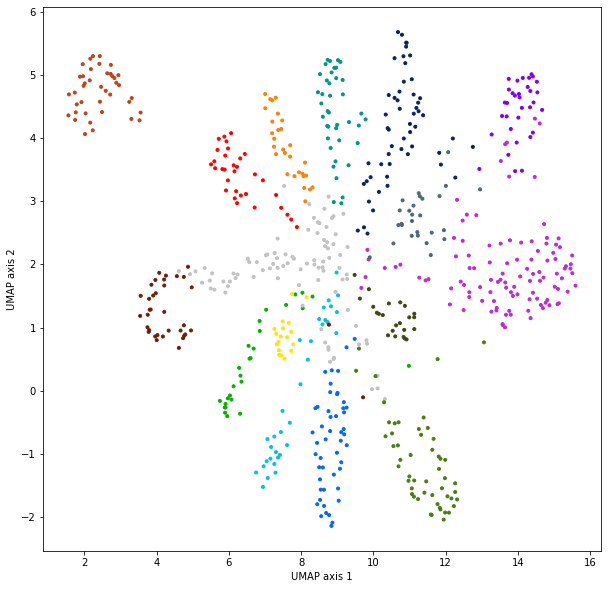

In [39]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

In [40]:
import umap
reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(newBasis)
#majcomp = np.argmax(newBasis, axis=1)

<Figure size 432x288 with 0 Axes>

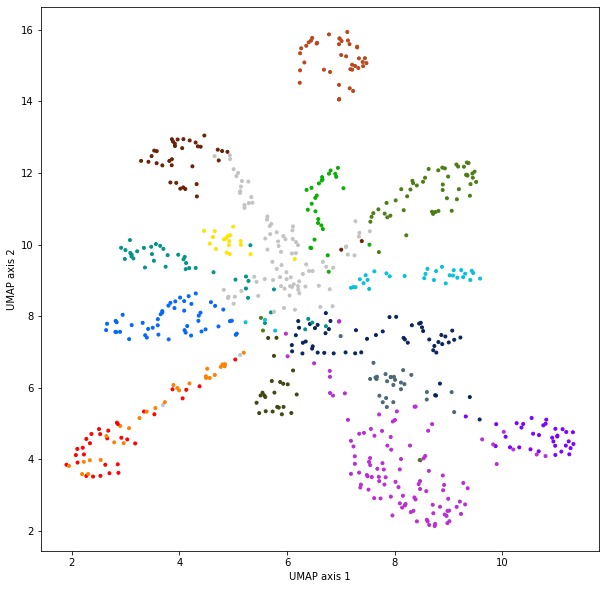

In [41]:
plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=Comp_colors[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

In [56]:
df = pd.DataFrame(data=newBasis)
round(df.head(20)).astype(int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,2,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,1,0,1,0,1,0,0,2,1,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4
8,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0


In [81]:
feh = metadata[hemo_uniq_cut]
feh.iloc[3]

DS_plus                         DS8235
repls                           DS8416
DCC.SPOT1                        0.719
system                       Digestive
Unique.cellular.condition            1
Name: 4, dtype: object

In [79]:
df[8].rank(ascending=False).head(10)

0    450.5
1    174.0
2    450.5
3    450.5
4    450.5
5    107.0
6     49.0
7    450.5
8    450.5
9    450.5
Name: 8, dtype: float64

In [199]:
metadata[hemo_uniq_cut][533:534]

,DS_plus,repls,DCC.SPOT1,system,Unique.cellular.condition
587,DS24731A,NaN,0.4953,Cardiovascular,1


In [80]:
a.writeNMF_CSV(Basis_foutname= '../data/2020-04-15NC16_NNDSVD_hemoNonUniqOnly_Basis.tsv', Mixture_foutname='../data/2020-04-15NC16_NNDSVD_hemoNonUniqOnly_Mixture.tsv')